In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2

In [2]:
DATADIR = Path("data")

In [3]:
from data_processing import *
import data_processing as dp

from train import *

# Correlations
Create a correlation matrix for the dataset, see if staying at home correlates significantly with PHQ9

In [4]:
def preprocessed_data(TYPE="classification", TARGET="value"):
    phq9 = dp.load_phq9_targets(DATADIR / "df_phq9.csv", type=TYPE, target=TARGET)
    locations = load_locations(DATADIR / "df_location_ratio.csv")
    demographics = load_demographics(DATADIR / "df_demographics.csv")
    # mobility = load_passive_mobility(DATADIR / 'df_passive_mobility_features.csv')
    # phone = load_passive_phone(DATADIR / 'df_passive_phone_communication_features_brighten_v2.csv')

    combined, _ = dp.combine(
        phq9,
        dailies=[
            ("locations", locations),
            # ('mobility', mobility),
            # ('phone', phone)
        ],
        constants=[demographics],
        prev_phq9=False,
    )
    combined = dp.rf_preprocess(combined)
    return combined


def plot_correlations(TYPE="classification", TARGET="value", method="pearson"):
    combined = preprocessed_data(TYPE, TARGET)
    corr = combined.iloc[:, 2:]  # remove ID and date
    corr = corr.corr(method=method).iloc[
        0, :
    ]  # take only correlations with target row (first row)
    corr = corr.sort_values(ascending=False)
    plt.figure(figsize=(20, 20))
    sns.heatmap(corr.to_frame(), annot=True, cmap="coolwarm")
    plt.title(f"Correlation in the {TYPE} of PHQ9 {TARGET}")
    plt.show()

## Pearson standard correlation coefficient

In [5]:
combined = []
for i, (TYPE, TARGET) in enumerate(
    [
        ("classification", "value"),
        ("regression", "value"),
        ("classification", "diff"),
        ("regression", "diff"),
    ]
):
    combined.append(preprocessed_data(TYPE, TARGET))

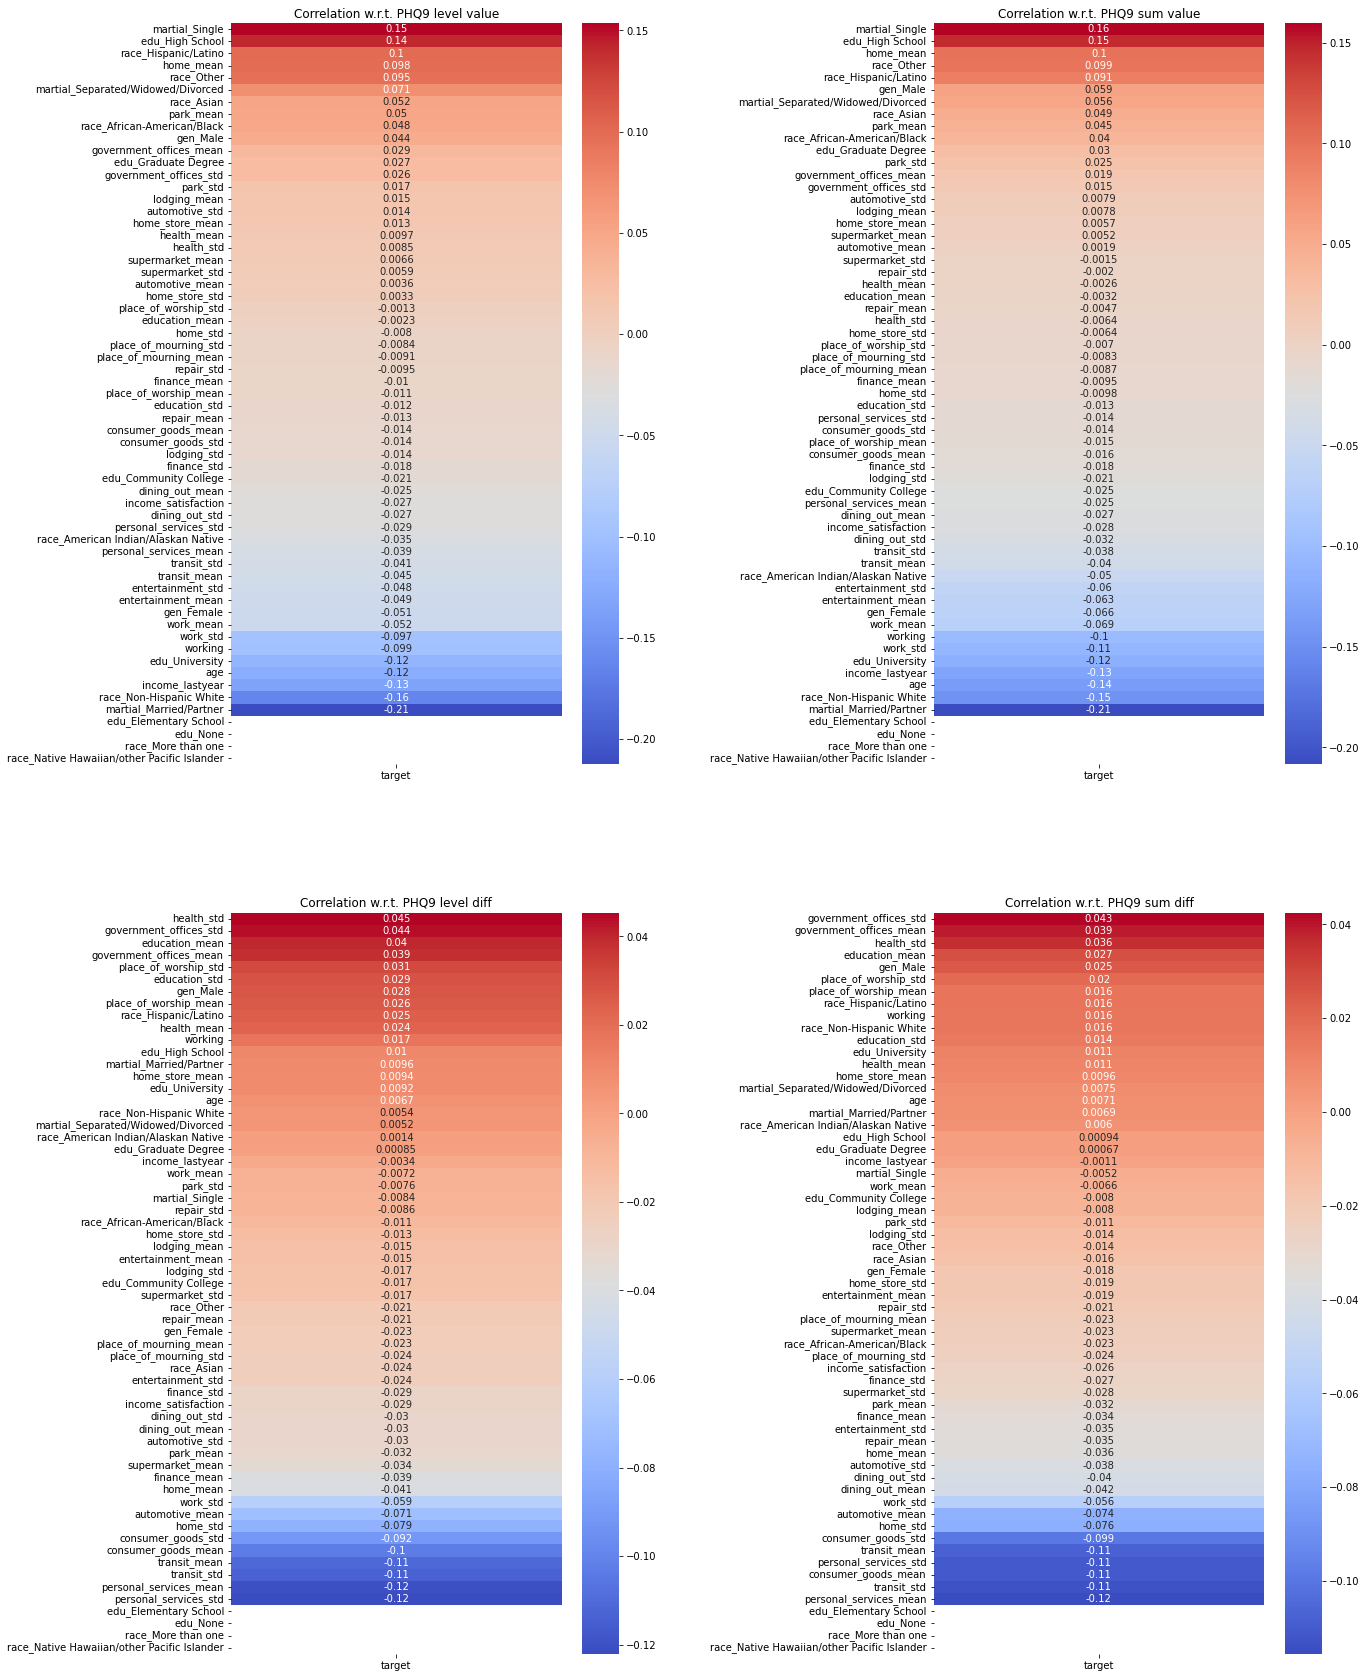

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 30))
for i, (TYPE, TARGET) in enumerate(
    [
        ("classification", "value"),
        ("regression", "value"),
        ("classification", "diff"),
        ("regression", "diff"),
    ]
):
    corr = combined[i].iloc[:, 2:]  # remove ID and date
    corr = corr.corr().iloc[0, :]  # take only correlations with target row (first row)
    corr = corr.drop("target").sort_values(
        ascending=False
    )  # correlation with target is always 1.0
    sns.heatmap(corr.to_frame(), annot=True, cmap="coolwarm", ax=axes[i // 2, i % 2])
    type_str = "level" if TYPE == "classification" else "sum"
    axes[i // 2, i % 2].set_title(f"Correlation w.r.t. PHQ9 {type_str} {TARGET}")
    # Increase the horizontal spacing between subplots
    fig.subplots_adjust(wspace=0.7)

## Spearman rank correlation

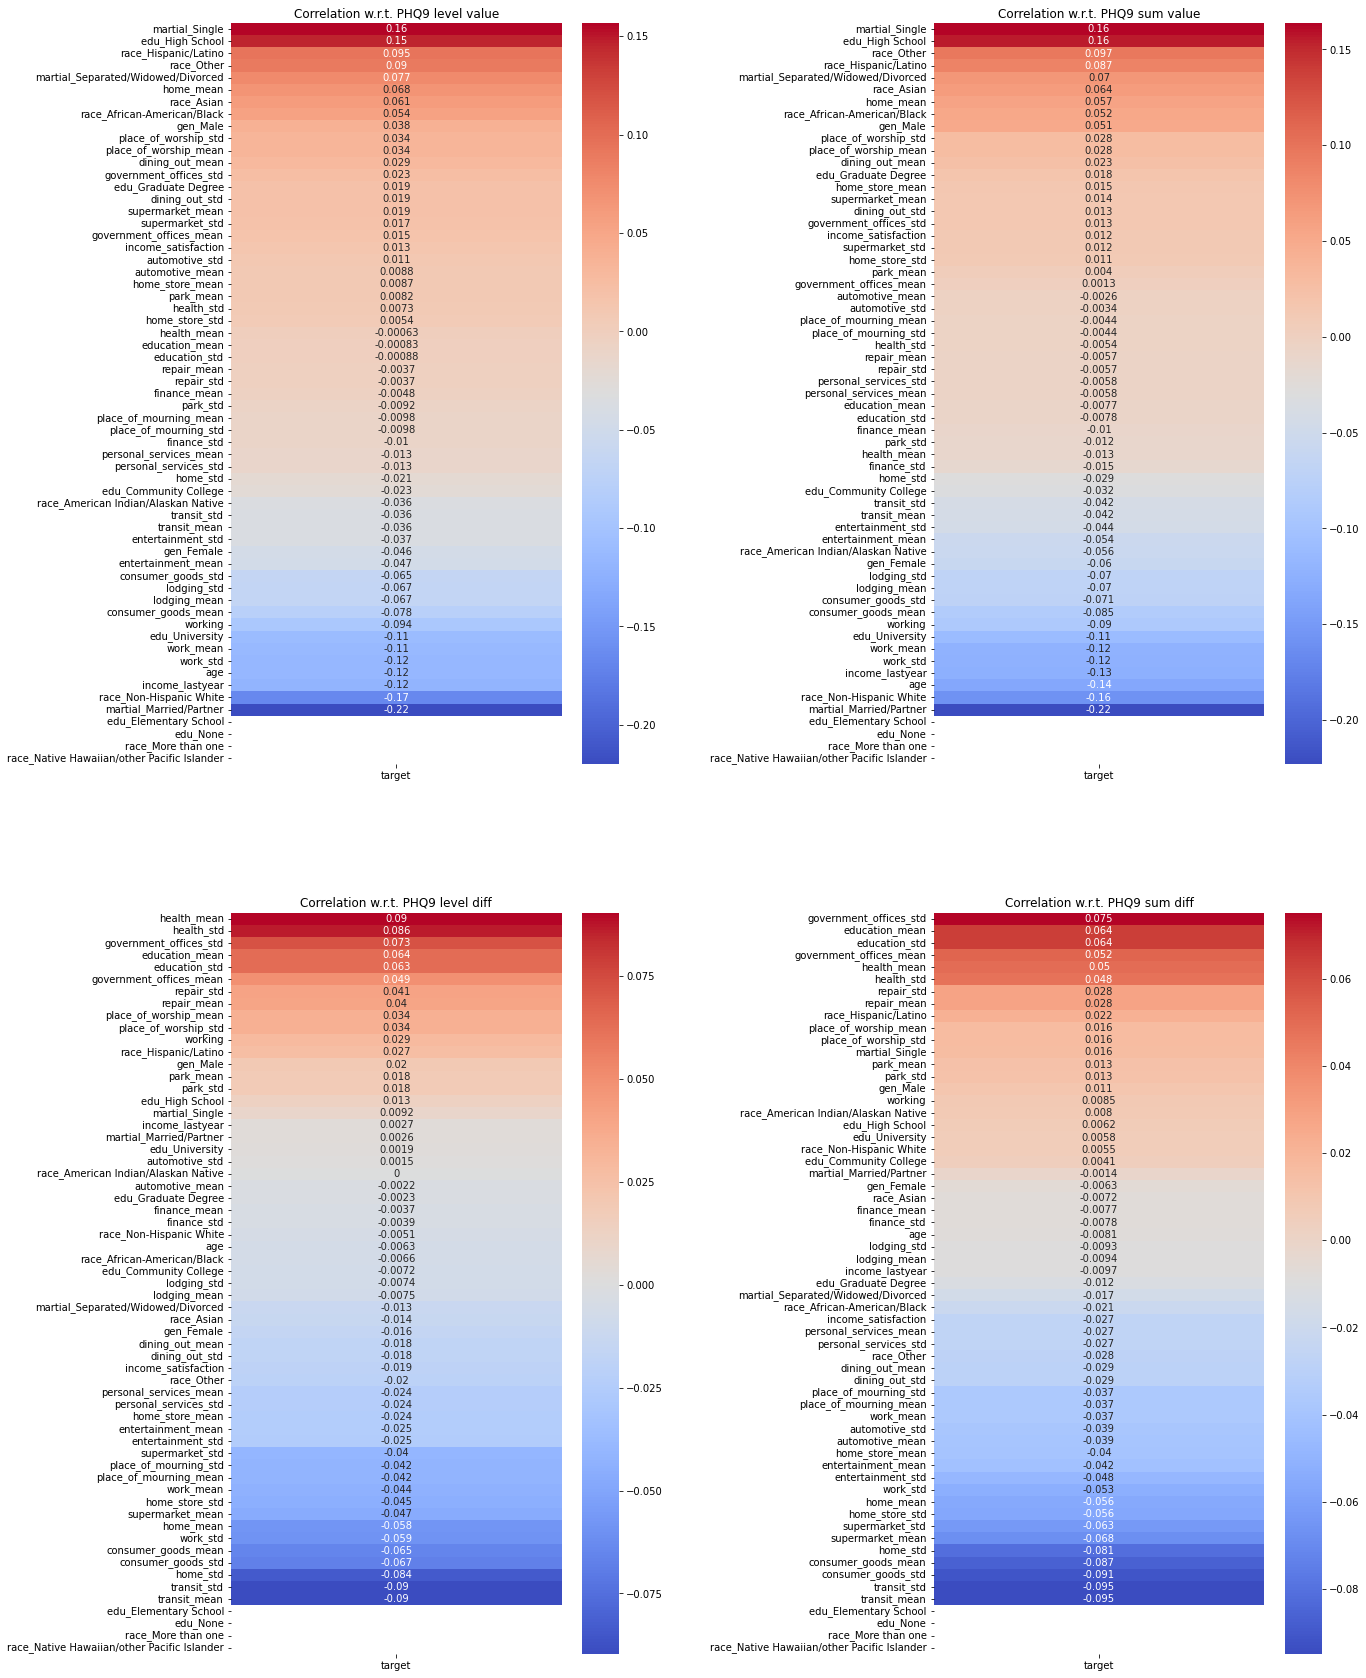

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 30))
for i, (TYPE, TARGET) in enumerate(
    [
        ("classification", "value"),
        ("regression", "value"),
        ("classification", "diff"),
        ("regression", "diff"),
    ]
):
    corr = combined[i].iloc[:, 2:]  # remove ID and date
    corr = corr.corr(method="spearman").iloc[
        0, :
    ]  # take only correlations with target row (first row)
    corr = corr.drop("target").sort_values(
        ascending=False
    )  # correlation with target is always 1.0
    sns.heatmap(corr.to_frame(), annot=True, cmap="coolwarm", ax=axes[i // 2, i % 2])
    type_str = "level" if TYPE == "classification" else "sum"
    axes[i // 2, i % 2].set_title(f"Correlation w.r.t. PHQ9 {type_str} {TARGET}")
    # Increase the horizontal spacing between subplots
    fig.subplots_adjust(wspace=0.7)

## p-value

/home/julien/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


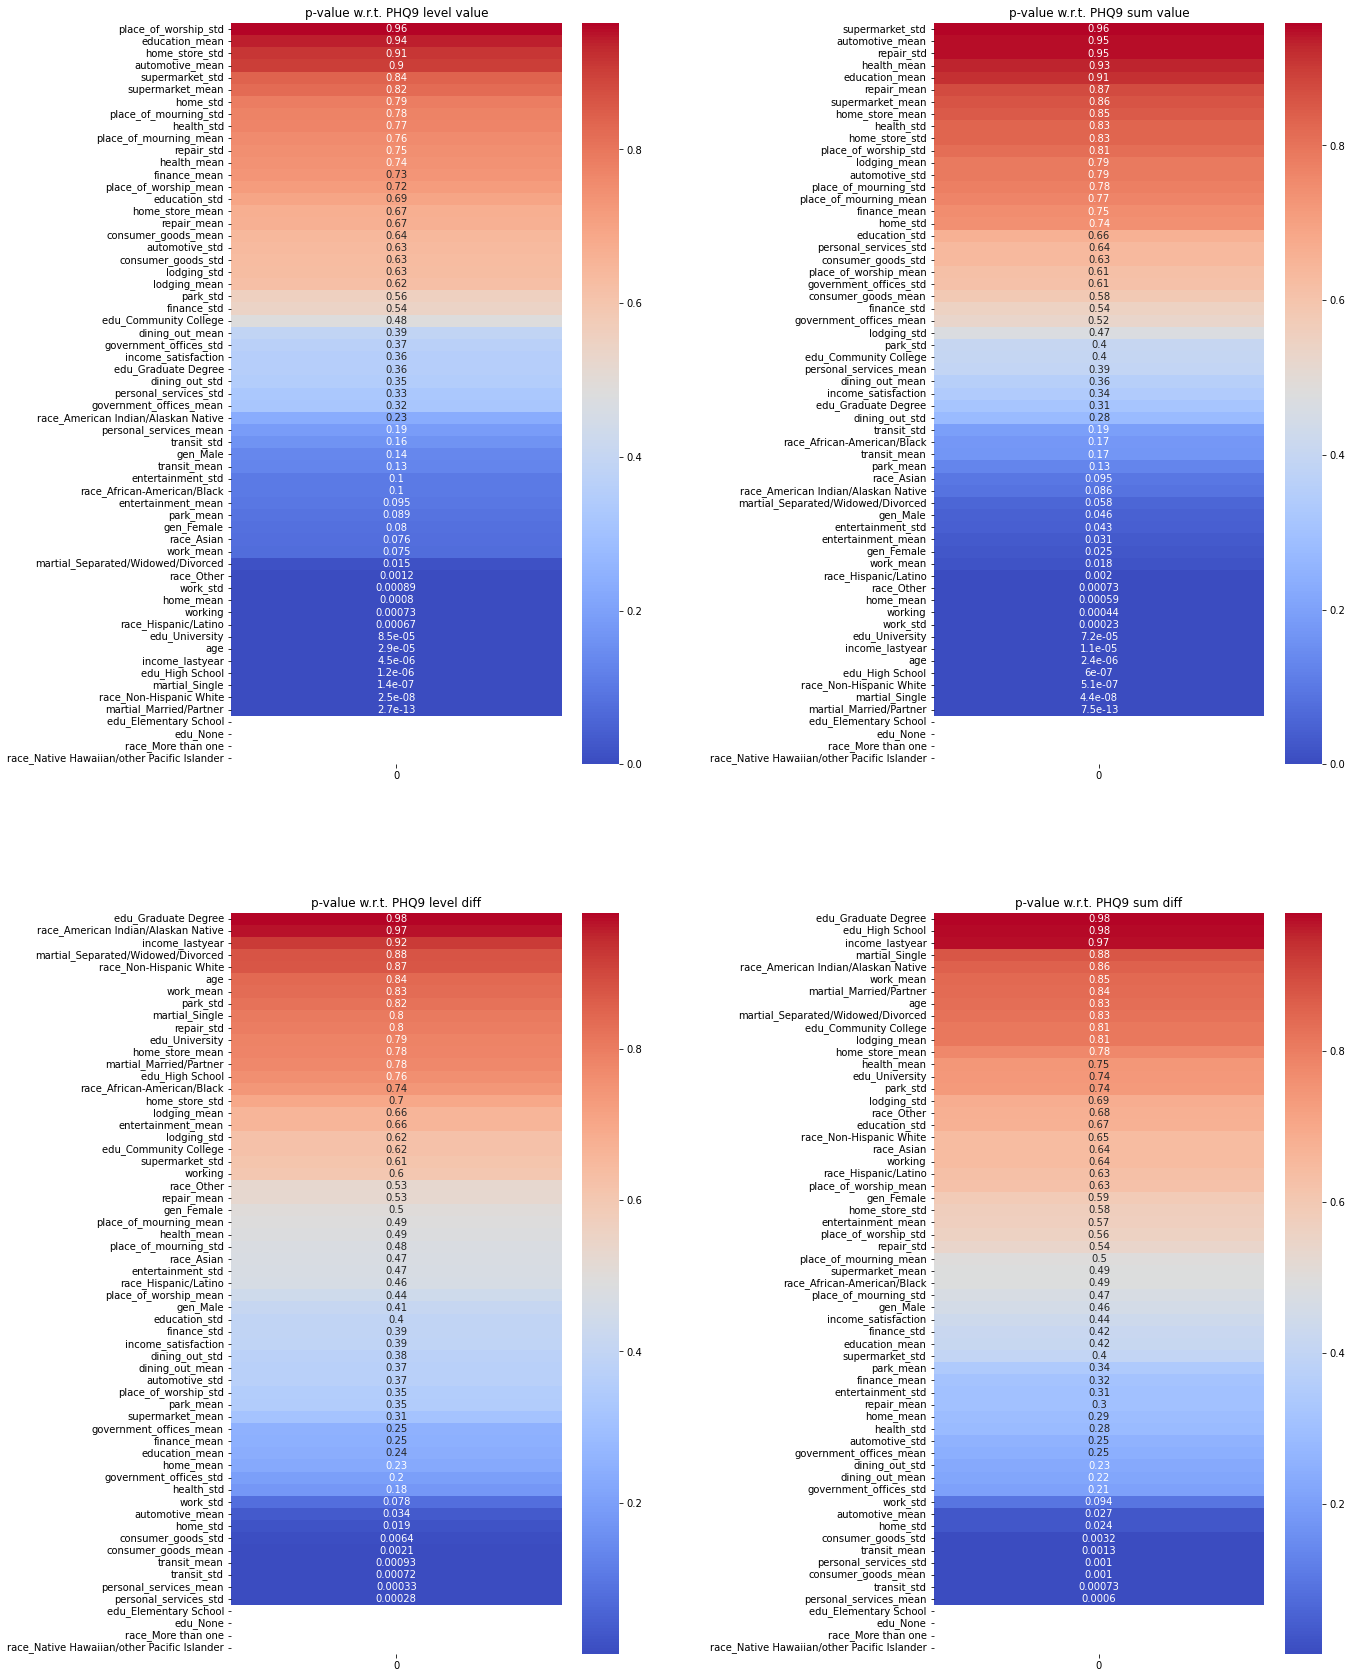

In [8]:
from scipy.stats import pearsonr

# Create a grid of plots with the four plot_correlations() plots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 30))
for i, (TYPE, TARGET) in enumerate(
    [
        ("classification", "value"),
        ("regression", "value"),
        ("classification", "diff"),
        ("regression", "diff"),
    ]
):
    combined_i = combined[i]
    columns = combined_i.columns[3:]  # no target, participant_id, date
    pvalues = [pearsonr(combined_i["target"], combined_i[c])[1] for c in columns]
    pvalues = pd.Series(pvalues, index=columns)
    pvalues = pvalues.sort_values(ascending=False)

    sns.heatmap(pvalues.to_frame(), annot=True, cmap="coolwarm", ax=axes[i // 2, i % 2])
    type_str = "level" if TYPE == "classification" else "sum"
    axes[i // 2, i % 2].set_title(f"p-value w.r.t. PHQ9 {type_str} {TARGET}")
    # Increase the horizontal spacing between subplots
    fig.subplots_adjust(wspace=0.7)

# PHQ9 levels (classification)
- 0  :   No depression                  195
- 1-4:   Minimal depression             790
- 5-9:   Mild depression                1760
- 10-14: Moderate depression            1111
- 15-19: Moderately severe depression   624
- 20-27: Severe depression              311

## 5 classes (base)

Train set shape: (986, 61)
Test set shape: (175, 61)
Ratio: 84.93%/15.07%

Train RMSE: 0.3185
Test RMSE:  1.0085
Train score: 94.52%
Test score:  50.29%

After feature selection:
Train set shape: (986, 25)
Test set shape: (175, 25)

Train score: 94.52%
Test score:  53.71%


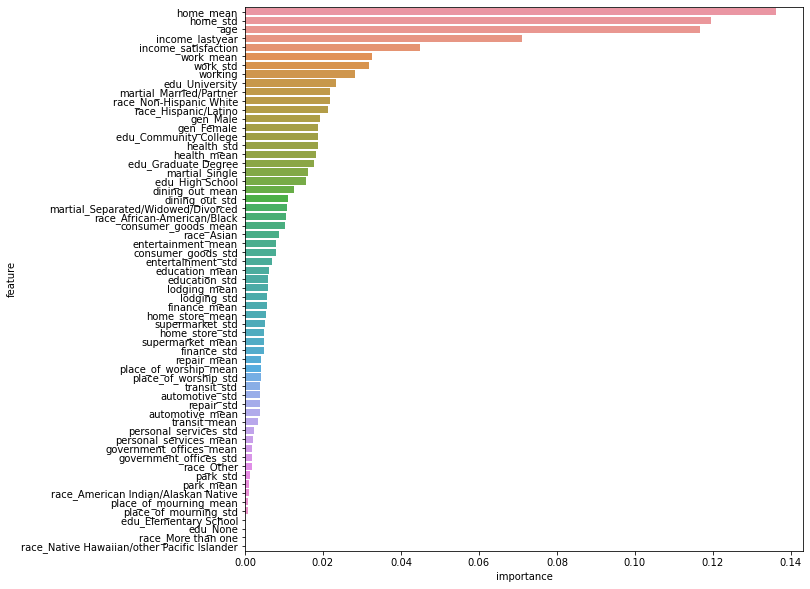

(94.52332657200812, 50.28571428571429, 94.52332657200812, 53.714285714285715)

In [9]:
train(
    TYPE="classification",
    TARGET="value",
    SPLIT_BY_PARTICIPANT=False,
    SEED=550,
    return_csv=False,
    feature_selection=True,
)

## 6 classes (all the classes)
- 0  :   No depression                  195
- 1-4:   Minimal depression             790
- 5-9:   Mild depression                1760
- 10-14: Moderate depression            1111
- 15-19: Moderately severe depression   624
- 20-27: Severe depression              311

In [10]:
partition_list = [
    1
    if i in range(1, 4 + 1)
    else 2
    if i in range(5, 9 + 1)
    else 3
    if i in range(10, 14 + 1)
    else 4
    if i in range(15, 19 + 1)
    else 5
    if i in range(20, 27 + 1)
    else 0
    for i in range(0, 27 + 1)
]
partition = {i: v for i, v in enumerate(partition_list)}

Train set shape: (986, 61)
Test set shape: (175, 61)
Ratio: 84.93%/15.07%

Train RMSE: 0.2568
Test RMSE:  1.0474
Train score: 95.23%
Test score:  45.71%

After feature selection:
Train set shape: (986, 25)
Test set shape: (175, 25)

Train score: 94.52%
Test score:  45.71%


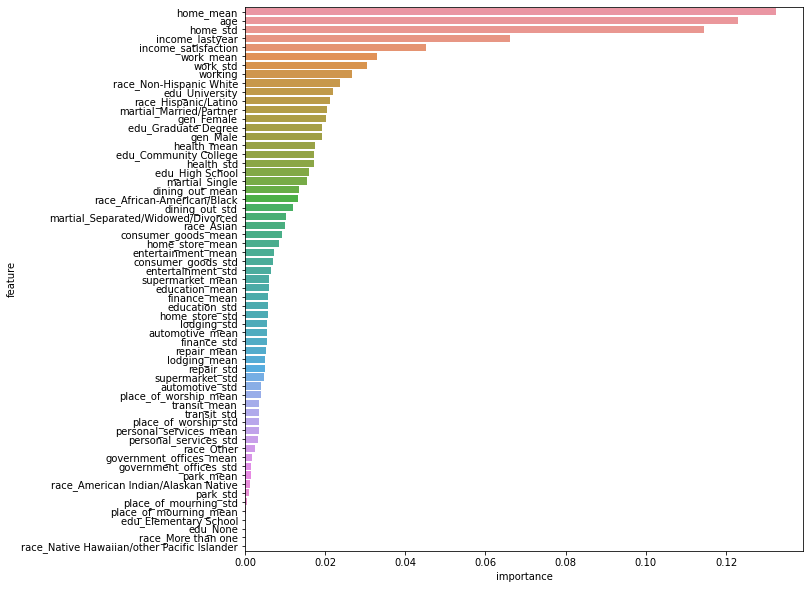

(95.23326572008114, 45.714285714285715, 94.52332657200812, 45.714285714285715)

In [11]:
train(
    TYPE="classification",
    TARGET="value",
    SPLIT_BY_PARTICIPANT=False,
    SEED=550,
    return_csv=False,
    feature_selection=True,
    partition=partition,
)

## 3 classes
- **0-4**: Class 0 (None, Minimal) 
- **5-14**: Class 1 (Mild, Moderate)
- **15-27**: Class 2 (Moderately severe, Severe)

In [12]:
partition_list = [
    0
    if i in range(0, 4)
    else 1
    if i in range(5, 14 + 1)
    else 2
    if i in range(15, 27 + 1)
    else 0
    for i in range(0, 27 + 1)
]
partition = {i: v for i, v in enumerate(partition_list)}

Train set shape: (986, 61)
Test set shape: (175, 61)
Ratio: 84.93%/15.07%

Train RMSE: 0.1773
Test RMSE:  0.5398
Train score: 96.86%
Test score:  70.86%

After feature selection:
Train set shape: (986, 24)
Test set shape: (175, 24)

Train score: 96.65%
Test score:  71.43%


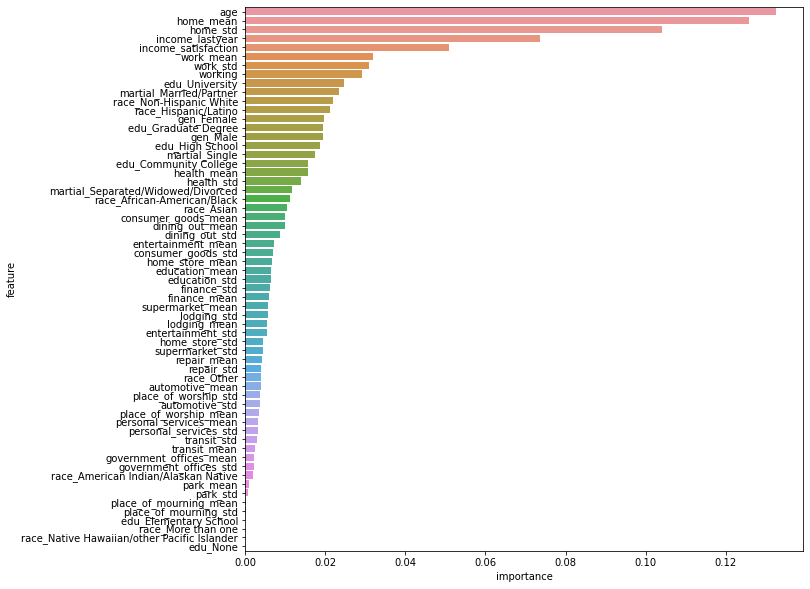

(96.85598377281947, 70.85714285714285, 96.65314401622717, 71.42857142857143)

In [13]:
train(
    TYPE="classification",
    TARGET="value",
    SPLIT_BY_PARTICIPANT=False,
    SEED=550,
    return_csv=False,
    feature_selection=True,
    partition=partition,
)

## 4 classes (mail)
- **0**:     Class 0 (None)
- **1-9**:   Class 1 (Minimal, Mild)
- **10-19**: Class 2 (Moderate, Moderately severe)
- **20-27**: Class 3 (Severe)

In [14]:
partition_list = [
    0
    if i == 0
    else 1
    if i in range(1, 9 + 1)
    else 2
    if i in range(10, 19 + 1)
    else 3
    if i in range(20, 27 + 1)
    else 0
    for i in range(0, 27 + 1)
]
partition = {i: v for i, v in enumerate(partition_list)}

Train set shape: (986, 61)
Test set shape: (175, 61)
Ratio: 84.93%/15.07%

Train RMSE: 0.2039
Test RMSE:  0.6094
Train score: 96.45%
Test score:  69.71%

After feature selection:
Train set shape: (986, 24)
Test set shape: (175, 24)

Train score: 96.15%
Test score:  66.29%


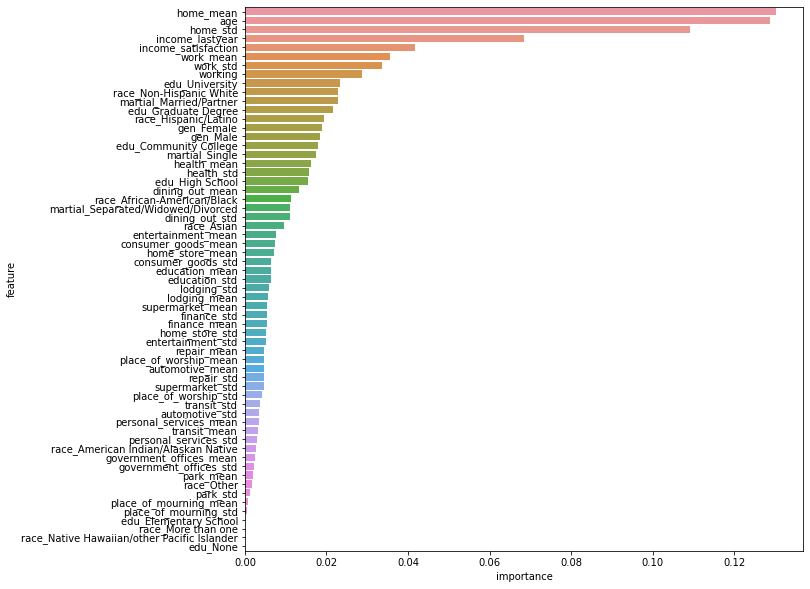

(96.45030425963489, 69.71428571428572, 96.14604462474645, 66.28571428571428)

In [15]:
train(
    TYPE="classification",
    TARGET="value",
    SPLIT_BY_PARTICIPANT=False,
    SEED=550,
    return_csv=False,
    feature_selection=True,
    partition=partition,
)

## 4 classes
- **0-4**:     Class 0 (None, Minimal)
- **5-9**:   Class 1 (Mild)
- **10-14**: Class 2 (Moderate)
- **15-27**: Class 3 (Moderately severe, Severe)

In [16]:
partition_list = [
    0
    if i in range(0, 4)
    else 1
    if i in range(5, 9 + 1)
    else 2
    if i in range(10, 14 + 1)
    else 3
    if i in range(15, 27 + 1)
    else 0
    for i in range(0, 27 + 1)
]
partition = {i: v for i, v in enumerate(partition_list)}

Train set shape: (986, 61)
Test set shape: (175, 61)
Ratio: 84.93%/15.07%

Train RMSE: 0.2340
Test RMSE:  0.9008
Train score: 95.74%
Test score:  57.14%

After feature selection:
Train set shape: (986, 24)
Test set shape: (175, 24)

Train score: 95.13%
Test score:  59.43%


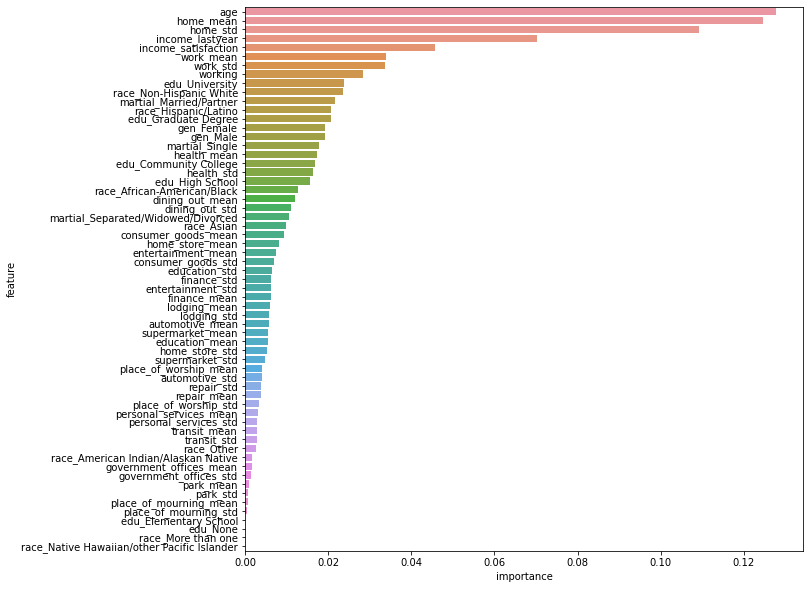

(95.74036511156187, 57.14285714285714, 95.131845841785, 59.42857142857143)

In [17]:
train(
    TYPE="classification",
    TARGET="value",
    SPLIT_BY_PARTICIPANT=False,
    SEED=550,
    return_csv=False,
    feature_selection=True,
    partition=partition,
    verbose=True,
)

## All combinations

In [18]:
partitions = []
partition_list = [
    0
    if i in range(0, 4)
    else 1
    if i in range(5, 14 + 1)
    else 2
    if i in range(15, 27 + 1)
    else 0
    for i in range(0, 27 + 1)
]
partitions.append({i: v for i, v in enumerate(partition_list)})

partition_list = [
    0
    if i == 0
    else 1
    if i in range(1, 9 + 1)
    else 2
    if i in range(10, 19 + 1)
    else 3
    if i in range(20, 27 + 1)
    else 0
    for i in range(0, 27 + 1)
]
partitions.append({i: v for i, v in enumerate(partition_list)})


partition_list = [
    0
    if i in range(0, 4)
    else 1
    if i in range(5, 9 + 1)
    else 2
    if i in range(10, 14 + 1)
    else 3
    if i in range(15, 27 + 1)
    else 0
    for i in range(0, 27 + 1)
]
partitions.append({i: v for i, v in enumerate(partition_list)})

partitions.append(None)


partition_list = [
    1
    if i in range(1, 4 + 1)
    else 2
    if i in range(5, 9 + 1)
    else 3
    if i in range(10, 14 + 1)
    else 4
    if i in range(15, 19 + 1)
    else 5
    if i in range(20, 27 + 1)
    else 0
    for i in range(0, 27 + 1)
]
partitions.append({i: v for i, v in enumerate(partition_list)})

### Class imbalance

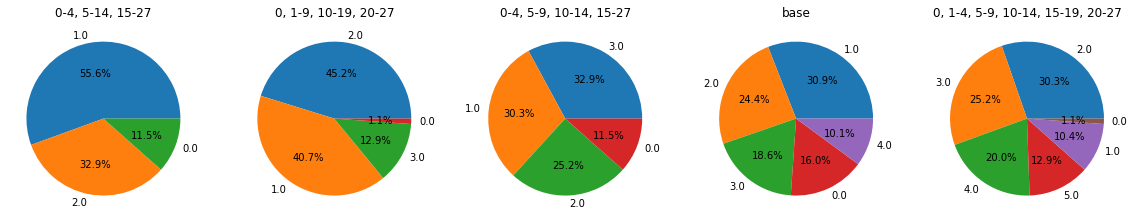

In [19]:
datas = []

for partition in partitions:
    datas.append(
        train(
            TYPE="classification",
            TARGET="value",
            return_csv=True,
            partition=partition,
        )
    )

partitions_str = [
    "0-4, 5-14, 15-27",
    "0, 1-9, 10-19, 20-27",
    "0-4, 5-9, 10-14, 15-27",
    "base",
    "0, 1-4, 5-9, 10-14, 15-19, 20-27",
]

fig, axs = plt.subplots(1, len(partitions), figsize=(20, len(partitions)))
for i, data in enumerate(datas):
    axs[i].pie(
        data["target"].value_counts(),
        labels=data["target"].value_counts().index,
        autopct="%1.1f%%",
    )
    axs[i].set_title(partitions_str[i])
plt.show()

### Scores

In [20]:
df = pd.read_csv("partition_results.csv")
df

,partition,train,test,train (fs),test (fs),SPLIT,TTF
0,"0-4, 5-14, 15-27",96.855984,70.857143,96.653144,71.428571,False,0
1,"0, 1-9, 10-19, 20-27",96.450304,69.714286,96.146045,66.285714,False,0
2,"0-4, 5-9, 10-14, 15-27",95.740365,57.142857,95.131846,59.428571,False,0
3,base,94.523327,50.285714,94.523327,53.714286,False,0
4,"0, 1-4, 5-9, 10-14, 15-19, 20-27",95.233266,45.714286,94.523327,45.714286,False,0
5,"0-4, 5-14, 15-27",96.800826,56.250000,96.594427,60.416667,True,0
6,"0, 1-9, 10-19, 20-27",96.284830,46.875000,95.975232,45.833333,True,0
7,"0-4, 5-9, 10-14, 15-27",94.943240,39.583333,94.530444,39.062500,True,0
8,base,94.117647,26.562500,93.911249,28.645833,True,0
9,"0, 1-4, 5-9, 10-14, 15-19, 20-27",93.808050,27.083333,93.292054,32.291667,True,0


In [21]:
df[df["train"] == df["train"].max()]

,partition,train,test,train (fs),test (fs),SPLIT,TTF
25,"0-4, 5-14, 15-27",96.89781,61.538462,96.624088,64.615385,True,4


In [22]:
df[df["train (fs)"] == df["train (fs)"].max()]

,partition,train,test,train (fs),test (fs),SPLIT,TTF
0,"0-4, 5-14, 15-27",96.855984,70.857143,96.653144,71.428571,False,0


In [23]:
df[df["test"] == df["test"].max()]

,partition,train,test,train (fs),test (fs),SPLIT,TTF
26,"0, 1-9, 10-19, 20-27",96.350365,76.923077,96.076642,73.846154,True,4


In [24]:
df[df["test (fs)"] == df["test (fs)"].max()]

,partition,train,test,train (fs),test (fs),SPLIT,TTF
26,"0, 1-9, 10-19, 20-27",96.350365,76.923077,96.076642,73.846154,True,4


In [25]:
df.sort_values(by="train", ascending=False)

,partition,train,test,train (fs),test (fs),SPLIT,TTF
25,"0-4, 5-14, 15-27",96.897810,61.538462,96.624088,64.615385,True,4
0,"0-4, 5-14, 15-27",96.855984,70.857143,96.653144,71.428571,False,0
20,"0-4, 5-14, 15-27",96.840149,68.235294,96.561338,67.058824,True,3
10,"0-4, 5-14, 15-27",96.837945,66.442953,96.640316,67.785235,True,1
5,"0-4, 5-14, 15-27",96.800826,56.250000,96.594427,60.416667,True,0
15,"0-4, 5-14, 15-27",96.752627,67.543860,96.466094,70.175439,True,2
1,"0, 1-9, 10-19, 20-27",96.450304,69.714286,96.146045,66.285714,False,0
21,"0, 1-9, 10-19, 20-27",96.375465,69.411765,96.096654,64.705882,True,3
26,"0, 1-9, 10-19, 20-27",96.350365,76.923077,96.076642,73.846154,True,4
11,"0, 1-9, 10-19, 20-27",96.343874,67.785235,96.047431,63.758389,True,1


In [26]:
df.sort_values(by="train (fs)", ascending=False)

,partition,train,test,train (fs),test (fs),SPLIT,TTF
0,"0-4, 5-14, 15-27",96.855984,70.857143,96.653144,71.428571,False,0
10,"0-4, 5-14, 15-27",96.837945,66.442953,96.640316,67.785235,True,1
25,"0-4, 5-14, 15-27",96.897810,61.538462,96.624088,64.615385,True,4
5,"0-4, 5-14, 15-27",96.800826,56.250000,96.594427,60.416667,True,0
20,"0-4, 5-14, 15-27",96.840149,68.235294,96.561338,67.058824,True,3
15,"0-4, 5-14, 15-27",96.752627,67.543860,96.466094,70.175439,True,2
1,"0, 1-9, 10-19, 20-27",96.450304,69.714286,96.146045,66.285714,False,0
21,"0, 1-9, 10-19, 20-27",96.375465,69.411765,96.096654,64.705882,True,3
26,"0, 1-9, 10-19, 20-27",96.350365,76.923077,96.076642,73.846154,True,4
11,"0, 1-9, 10-19, 20-27",96.343874,67.785235,96.047431,63.758389,True,1


In [27]:
df.sort_values(by="test", ascending=False)

,partition,train,test,train (fs),test (fs),SPLIT,TTF
26,"0, 1-9, 10-19, 20-27",96.350365,76.923077,96.076642,73.846154,True,4
0,"0-4, 5-14, 15-27",96.855984,70.857143,96.653144,71.428571,False,0
1,"0, 1-9, 10-19, 20-27",96.450304,69.714286,96.146045,66.285714,False,0
21,"0, 1-9, 10-19, 20-27",96.375465,69.411765,96.096654,64.705882,True,3
20,"0-4, 5-14, 15-27",96.840149,68.235294,96.561338,67.058824,True,3
11,"0, 1-9, 10-19, 20-27",96.343874,67.785235,96.047431,63.758389,True,1
15,"0-4, 5-14, 15-27",96.752627,67.543860,96.466094,70.175439,True,2
10,"0-4, 5-14, 15-27",96.837945,66.442953,96.640316,67.785235,True,1
16,"0, 1-9, 10-19, 20-27",96.275072,64.035088,95.988539,65.789474,True,2
25,"0-4, 5-14, 15-27",96.897810,61.538462,96.624088,64.615385,True,4


In [28]:
df.sort_values(by="test (fs)", ascending=False)

,partition,train,test,train (fs),test (fs),SPLIT,TTF
26,"0, 1-9, 10-19, 20-27",96.350365,76.923077,96.076642,73.846154,True,4
0,"0-4, 5-14, 15-27",96.855984,70.857143,96.653144,71.428571,False,0
15,"0-4, 5-14, 15-27",96.752627,67.543860,96.466094,70.175439,True,2
10,"0-4, 5-14, 15-27",96.837945,66.442953,96.640316,67.785235,True,1
20,"0-4, 5-14, 15-27",96.840149,68.235294,96.561338,67.058824,True,3
1,"0, 1-9, 10-19, 20-27",96.450304,69.714286,96.146045,66.285714,False,0
16,"0, 1-9, 10-19, 20-27",96.275072,64.035088,95.988539,65.789474,True,2
21,"0, 1-9, 10-19, 20-27",96.375465,69.411765,96.096654,64.705882,True,3
25,"0-4, 5-14, 15-27",96.897810,61.538462,96.624088,64.615385,True,4
11,"0, 1-9, 10-19, 20-27",96.343874,67.785235,96.047431,63.758389,True,1
